In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as mpatches
from matplotlib.colors import to_rgba
import warnings
warnings.filterwarnings('ignore')

# Add the root directory of the package to sys.path
sys.path.append('/Users/zzhang/Workspace/SpyDust/')
sys.path.append('../')

# Configure matplotlib for publication quality
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'Bitstream Vera Serif', 'serif'],
    'text.usetex': False,  # Set to True if LaTeX is available
    'figure.figsize': [10, 8],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.format': 'pdf',
    'axes.linewidth': 1.2,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6
})

# Check which font is actually being used
import matplotlib.font_manager as fm
font_prop = fm.FontProperties(family='serif')
print(f"Active serif font: {font_prop.get_name()}")
print(f"Available serif fonts: {[f.name for f in fm.fontManager.ttflist if 'serif' in f.name.lower()][:5]}")  # Show first 5

# Import SpyDust modules
import functools
import SpyDust.Grain as Grain
from SpyDust.SpyDust import SpyDust_given_grain_size_shape
from SpyDust.util import makelogtab, cgsconst
from SpyDust.SPDUST_as_is import emissivity
import matplotlib.cm as cm

from SpyDust.SED_fit import fit_sed_ensemble
from gsa_pipeline import gsa_pipeline


Active serif font: Times New Roman
Available serif fonts: ['DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DejaVu Serif']
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
I(Zg<0, parabolic) stored
I(rot, e, Zg <> 0) stored
Gaunt factor stored
l_a computed
readPAH computed
Loaded previously computed Jpeisrf arrays from file.
Maximum energy in the Qabs_hnu_tab is 1239.84 eV.
FIR_integral_charged shape: (30, 30)
Na: 30, Nchi: 30
Tev table already exists at /Users/zzhang/Workspace/SpyDust/SpyDust/Data_Files/Tev_30a_30chi.txt.
Gaunt factor stored


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
freqs = np.loadtxt('data/freq.txt')
MC_key_params = np.loadtxt('data/MC_key_params.txt')
MC_sed_key_params = np.loadtxt('data/MC_SED_key_params.txt')
# Remove unphysical SEDs (nan or negative values)
valid_indices_MC = ~np.isnan(MC_sed_key_params).any(axis=1) & (MC_sed_key_params > 0).all(axis=1)
MC_key_params = MC_key_params[valid_indices_MC]
MC_sed_key_params = MC_sed_key_params[valid_indices_MC]

DC_key_params = np.loadtxt('data/DC_key_params.txt')
DC_sed_key_params = np.loadtxt('data/DC_SED_key_params.txt')
# Remove unphysical SEDs (nan or negative values)
valid_indices_DC = ~np.isnan(DC_sed_key_params).any(axis=1) & (DC_sed_key_params > 0).all(axis=1)
DC_key_params = DC_key_params[valid_indices_DC]
DC_sed_key_params = DC_sed_key_params[valid_indices_DC]

HII_key_params = np.loadtxt('data/HII_key_params.txt')
HII_sed_key_params = np.loadtxt('data/HII_SED_key_params.txt')
# Remove unphysical SEDs (nan or negative values)
valid_indices_HII = ~np.isnan(HII_sed_key_params).any(axis=1) & (HII_sed_key_params > 0).all(axis=1)
HII_key_params = HII_key_params[valid_indices_HII]
HII_sed_key_params = HII_sed_key_params[valid_indices_HII]

In [3]:
from scipy.stats import gaussian_kde
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm

def monte_carlo_integral(params, data, p_target, q_sample=None):
    """
    Estimate integral of f(theta) over parameter space with target distribution p_target,
    using samples and importance sampling. If the sampling density q_sample is not provided,
    it is estimated from the samples using KDE.

    Parameters
    ----------
    params : np.ndarray, shape (N_samples, N_params)
        Sample points in the parameter space.
    data : np.ndarray, shape (N_samples, N_data)
        Function values at the sample points.
    p_target : callable
        Target probability density function p(theta), evaluated at each sample.
    q_sample : callable or None
        Sampling probability density function q(theta), evaluated at each sample.
        If None, estimated via KDE from params.

    Returns
    -------
    integral : np.ndarray, shape (N_data,)
        Estimated integral over parameter space.
    """
    params = np.asarray(params)
    data = np.asarray(data)

    p_vals = np.asarray(p_target(params))

    if q_sample is None:
        kde = gaussian_kde(params.T)
        q_vals = kde(params.T)
    else:
        q_vals = np.asarray(q_sample(params))

    weights = p_vals / q_vals
    weights_sum = np.sum(weights)
    if weights_sum == 0:
        raise ValueError("Importance weights sum to zero; cannot normalize.")
    weights /= weights_sum

    integral = np.sum(weights[:, None] * data, axis=0)
    return integral

def monte_carlo_Dirichlet_ensemble(params, data, p_target=None, q_sample=None, N_ensemble=10, alpha=1.0, show_progress=True):
    """
    Compute multiple ensemble integrals over saved samples using random weights.

    Parameters
    ----------
    params : np.ndarray, shape (N_samples, 3)
        Sample points in the 3D parameter space.
    data : np.ndarray, shape (N_samples, N_data)
        Function values at the sample points.
    p_target : callable or None
        Target probability density function p(theta). If None, uniform is assumed.
    q_sample : callable or None
        Sampling PDF q(theta). If None, KDE is used to estimate it.
    N_ensemble : int
        Number of ensemble realizations to generate.
    alpha : float
        Concentration parameter for the Dirichlet draw.
    show_progress : bool
        If True, display a tqdm progress bar for the ensemble loop.

    Returns
    -------
    ensemble_integrals : np.ndarray, shape (N_ensemble, N_data)
        Array of ensemble-integrated data.
    """
    params = np.asarray(params)
    data = np.asarray(data)
    N_samples = len(params)
    
    if N_samples == 0:
        raise ValueError("monte_carlo_ensemble received zero samples.")
    
    if p_target is None:
        p_vals = np.ones(N_samples)
    else:
        p_vals = np.asarray(p_target(params))
    
    if q_sample is None:
        kde = gaussian_kde(params.T)
        q_vals = kde(params.T)
    else:
        q_vals = np.asarray(q_sample(params))
    
    if np.any(q_vals <= 0):
        raise ValueError("Sampling PDF q(theta) must be strictly positive on the provided samples.")
    
    base_weights = p_vals / q_vals
    base_weights = np.clip(base_weights, 0.0, None)
    weight_sum = np.sum(base_weights)
    if weight_sum == 0:
        raise ValueError("All importance weights are zero; cannot form ensemble.")
    base_weights /= weight_sum
    
    positive_mask = base_weights > 0
    dirichlet_alpha = base_weights[positive_mask] * alpha
    if dirichlet_alpha.size == 0:
        raise ValueError("No positive weights remain after filtering; cannot draw from Dirichlet.")
    
    ensemble_integrals = []
    iterator = tqdm(range(N_ensemble), desc="Sampling ensembles", leave=False, disable=not show_progress)
    for _ in iterator:
        random_weights = np.zeros_like(base_weights)
        random_weights[positive_mask] = np.random.dirichlet(dirichlet_alpha)
        weighted_sum = np.sum(random_weights[:, None] * data, axis=0)
        ensemble_integrals.append(weighted_sum)
    
    return np.array(ensemble_integrals)

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from tqdm.auto import tqdm
import SpyDust.Grain as Grain


def grain_size_dist(gamma, log_a0, sigma, log_beta0, delta, log_p_c, log_p_width):
    """
    dn/da propto exp[(gamma - 1) lna - 1/2 ((ln(a) - ln(a0) + sigma**2/2)^2 / sigma^2)]
    """
    def dist_func(theta):
        a, beta, p = theta[:, 0], theta[:, 1], theta[:, 2]
        ln_a_list = np.log(a)
        exponent_a = (gamma-1)  * ln_a_list - 0.5 * ( (ln_a_list - log_a0 + sigma**2/2) / sigma ) ** 2
        
        ln_beta_t_tab = np.log( beta + 0.5 )
        exponent_beta = - ln_beta_t_tab - 0.5 * ( (ln_beta_t_tab  - log_beta0 + delta**2/2 ) / delta ) ** 2

        log_p = np.log(p)  
        exponent_env = - log_p - 0.5 * ( (log_p  - log_p_c + log_p_width**2/2 ) / log_p_width ) ** 2

        exponent = exponent_a + exponent_beta + exponent_env

        max_exponent = np.max(exponent)
        exponent -= max_exponent
        weights = np.exp(exponent)
        return weights
    return dist_func

def _integral_task(args):
    dist_params, X_arr, Y_arr = args
    gamma, log_a0, sigma, log_beta0, delta, log_p_c, log_p_width = dist_params
    p_target = grain_size_dist(gamma, log_a0, sigma, log_beta0, delta, log_p_c, log_p_width)
    return monte_carlo_integral(X_arr, Y_arr, p_target=p_target, q_sample=None)

class ensemble_model:
    gamma_min = -3.0
    gamma_max = 3.0

    log_a0_min = np.log(1e-9) 
    log_a0_max = np.log(1e-6)

    sigma_min = 0.01
    sigma_max = 20.0

    log_beta0_min = np.log(0.05)
    log_beta0_max = np.log(2)

    delta_min = 0.001
    delta_max = 20.0
    
    log_p_width_min = 0.001
    log_p_width_max = 20.0

    def __init__(self, log_p_c_min, log_p_c_max):
        self.log_p_c_min = log_p_c_min
        self.log_p_c_max = log_p_c_max

    def generate_params_samples(self, N_samples):
        gamma_list = np.random.uniform(self.gamma_min, self.gamma_max, N_samples)
        log_a0_list = np.random.uniform(self.log_a0_min, self.log_a0_max, N_samples)
        sigma_list = np.random.uniform(self.sigma_min, self.sigma_max, N_samples)
        log_beta0_list = np.random.uniform(self.log_beta0_min, self.log_beta0_max, N_samples)
        delta_list = np.random.uniform(self.delta_min, self.delta_max, N_samples)
        log_p_c_list = np.random.uniform(self.log_p_c_min, self.log_p_c_max, N_samples)
        log_p_width_list = np.random.uniform(self.log_p_width_min, self.log_p_width_max, N_samples)

        params = np.vstack([
            gamma_list,
            log_a0_list,
            sigma_list,
            log_beta0_list,
            delta_list,
            log_p_c_list,
            log_p_width_list
        ]).T
        return params
    
    def analysis(self, X_arr, Y_arr, num_samples=1000, max_workers=None, show_progress=True):
        X_arr = np.asarray(X_arr)
        Y_arr = np.asarray(Y_arr)

        params = self.generate_params_samples(num_samples)
        
        if max_workers is None:
            cpu_count = os.cpu_count() or 1
            max_workers = min(32, cpu_count)

        tasks = ((params[i], X_arr, Y_arr) for i in range(num_samples))
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            iterator = executor.map(_integral_task, tasks)
            if show_progress:
                iterator = tqdm(iterator, total=num_samples, desc="Evaluating ensembles", leave=False)
            results = list(iterator)
        
        return params, np.asarray(results)




In [ ]:
N_samples = 5000

MC_dist_model = ensemble_model(log_p_c_min=np.log(1e-6), log_p_c_max=np.log(1e-2))
MC_dist_ensem_params, MC_dist_ensem_sed = MC_dist_model.analysis(MC_key_params[:, [6,7,4]], MC_sed_key_params, num_samples=N_samples, max_workers=30, show_progress=True)
MC_dist_ensem_features = fit_sed_ensemble(
    freqs, 
    MC_dist_ensem_sed, 
    thres=1e-3, 
    v2=False
)
MC_dist_ensem_features[:, 0] = np.exp(MC_dist_ensem_features[:, 0])


100%|██████████| 5000/5000 [00:00<00:00, 5131.00it/s]                        


Evaluating ensembles:   0%|          | 5/5000 [00:24<2:44:08,  1.97s/it]

In [ ]:
N_samples = 5000

DC_dist_model = ensemble_model(log_p_c_min=np.log(1e-8), log_p_c_max=np.log(1e-4))
DC_dist_ensem_params, DC_dist_ensem_sed = DC_dist_model.analysis(DC_key_params[:, [6,7,4]], DC_sed_key_params, num_samples=N_samples, max_workers=30, show_progress=True)
DC_dist_ensem_features = fit_sed_ensemble(
    freqs, 
    DC_dist_ensem_sed, 
    thres=1e-3, 
    v2=False
)
DC_dist_ensem_features[:, 0] = np.exp(DC_dist_ensem_features[:, 0])

In [ ]:
N_samples = 5000

HII_dist_model = ensemble_model(log_p_c_min=np.log(1.), log_p_c_max=np.log(1e5))
HII_dist_ensem_params, HII_dist_ensem_sed = HII_dist_model.analysis(HII_key_params[:, [6,7,0]], HII_sed_key_params, num_samples=N_samples, max_workers=30, show_progress=True)
HII_dist_ensem_features = fit_sed_ensemble(
    freqs, 
    HII_dist_ensem_sed, 
    thres=1e-3, 
    v2=False
)
HII_dist_ensem_features[:, 0] = np.exp(HII_dist_ensem_features[:, 0])

In [ ]:
# Save the data
np.savetxt("data/MC_dist_ensem_params.txt", MC_dist_ensem_params)
np.savetxt("data/MC_dist_ensem_sed.txt", MC_dist_ensem_sed)
np.savetxt("data/MC_dist_ensem_features.txt", MC_dist_ensem_features)

np.savetxt("data/DC_dist_ensem_params.txt", DC_dist_ensem_params)
np.savetxt("data/DC_dist_ensem_sed.txt", DC_dist_ensem_sed)
np.savetxt("data/DC_dist_ensem_features.txt", DC_dist_ensem_features)

np.savetxt("data/HII_dist_ensem_params.txt", HII_dist_ensem_params)
np.savetxt("data/HII_dist_ensem_sed.txt", HII_dist_ensem_sed)
np.savetxt("data/HII_dist_ensem_features.txt", HII_dist_ensem_features)

In [ ]:
# Your arrays
# X: (N_samples, N_params)
# Y: (N_samples, 2)  # columns: [peak_frequency, width]
param_names = ["gamma","log_a","sigma","log_beta","delta","log_p","logp_width"]  # adjust to your order

MC_out = gsa_pipeline(
    MC_dist_ensem_params, MC_dist_ensem_features,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = MC_out["results"]["nu_peak"]["table"]
table_width = MC_out["results"]["width"]["table"]
print(table_peak.round(4))
print(table_width.round(4))

                MI    dCor  PermMean  PermStd   ARD_LS      S1  S1_conf  \
logp_width  0.1667  0.2440    0.8120   0.0390   1.0324  0.1003   0.0873   
log_p       0.0826  0.2867    0.8476   0.0653   1.6386  0.0998   0.0618   
gamma       1.0250  0.7253    0.6356   0.0235   6.4751  0.2453   0.0560   
sigma       0.0922  0.0788    0.1043   0.0071   0.5080 -0.0120   0.0800   
log_a       0.0336  0.1074    0.1078   0.0209   1.6528  0.0565   0.0608   
delta       0.0070  0.0721    0.0089   0.0013   4.9347 -0.0004   0.0088   
log_beta    0.0309  0.0360    0.0025   0.0009  19.5803  0.0030   0.0050   

                ST  ST_conf  1/ARD_LS  AggRank  
logp_width  0.4307   0.0825    0.9686      2.0  
log_p       0.3809   0.0865    0.6103      2.4  
gamma       0.2541   0.0391    0.1544      3.0  
sigma       0.2647   0.0625    1.9686      3.4  
log_a       0.2387   0.1089    0.6050      4.4  
delta       0.0115   0.0064    0.2026      6.0  
log_beta    0.0028   0.0007    0.0511      6.8  
       

In [13]:

param_names = ["gamma","log_a","sigma","log_beta","delta","log_p","logp_width"]  # adjust to your order

DC_out = gsa_pipeline(
    DC_dist_ensem_params, DC_dist_ensem_features,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = DC_out["results"]["nu_peak"]["table"]
table_width = DC_out["results"]["width"]["table"]
print(table_peak.round(4))
print(table_width.round(4))

                MI    dCor  PermMean  PermStd  ARD_LS      S1  S1_conf  \
sigma       0.0891  0.1269    0.7212   0.0833  0.1390  0.1375   0.2171   
logp_width  0.0901  0.1745    0.3923   0.0361  0.8076  0.0270   0.0418   
gamma       1.4447  0.7668    0.3785   0.0144  2.7247  0.1358   0.0410   
log_a       0.0000  0.1062    0.6063   0.1339  0.8361  0.0442   0.0406   
log_p       0.0405  0.1840    0.3453   0.0454  1.6106  0.0224   0.0328   
delta       0.0163  0.0699    0.0360   0.0048  2.7197 -0.0093   0.0150   
log_beta    0.0224  0.0676    0.0273   0.0061  4.8192  0.0018   0.0120   

                ST  ST_conf  1/ARD_LS  AggRank  
sigma       0.7491   0.2001    7.1922      2.0  
logp_width  0.1459   0.0499    1.2382      2.6  
gamma       0.1411   0.0375    0.3670      3.2  
log_a       0.5359   0.2194    1.1960      3.8  
log_p       0.1203   0.0446    0.6209      4.0  
delta       0.0272   0.0082    0.3677      5.8  
log_beta    0.0124   0.0047    0.2075      6.6  
               

In [15]:

param_names = ["gamma","log_a","sigma","log_beta","delta","log_p","logp_width"]  # adjust to your order

HII_out = gsa_pipeline(
    HII_dist_ensem_params, HII_dist_ensem_features,
    feature_names=["nu_peak", "width"],
    param_names=param_names,
    scaler="standard",            # try "minmax" or None as well
    kernel_kind="rbf",             # try "rbf", "matern32", "matern52", "rq"
    ard=True,
    length_scale_init=1.0,        # or np.ones(d_kept) after dropping consts (handled internally)
    enable_perm=True,
    enable_gp=True,
    enable_sobol=True,
    make_pdp=True,
    N_sobol=1024,                 # increase for tighter Sobol CIs
    drop_const_atol=0.0,
    topk_pdp=3,
    pdp_prefix="pdp_demo",
    gp_random_state=0,
)

table_peak  = HII_out["results"]["nu_peak"]["table"]
table_width = HII_out["results"]["width"]["table"]
print(table_peak.round(4))
print(table_width.round(4))

                MI    dCor  PermMean  PermStd   ARD_LS      S1  S1_conf  \
logp_width  0.3774  0.4627    1.5443   0.1067   0.3415  0.2785   0.1022   
log_p       0.3406  0.4393    1.2583   0.1012   0.8249  0.2151   0.0880   
sigma       0.0636  0.0534    0.0386   0.0040   0.9394  0.0192   0.0513   
gamma       0.1800  0.1550    0.0219   0.0035   5.5204  0.0063   0.0075   
log_a       0.0343  0.0504    0.0226   0.0052   1.9513  0.0252   0.0559   
delta       0.0293  0.0561    0.0057   0.0010   3.0075  0.0009   0.0068   
log_beta    0.0203  0.0596   -0.0009   0.0028  16.0633  0.0079   0.0115   

                ST  ST_conf  1/ARD_LS  AggRank  
logp_width  0.7562   0.1256    2.9285      1.0  
log_p       0.6938   0.1601    1.2123      2.0  
sigma       0.0467   0.0259    1.0645      3.8  
gamma       0.0123   0.0032    0.1811      4.4  
log_a       0.0433   0.0294    0.5125      4.8  
delta       0.0120   0.0038    0.3325      5.6  
log_beta    0.0024   0.0009    0.0623      6.4  
       

In [ ]:
# from SpyDust.SED_fit import fit_sed_ensemble

# MC_feature_key_params = fit_sed_ensemble(
#     freqs, 
#     MC_sed_key_params, 
#     thres=1e-3, 
#     v2=False
# )
# MC_feature_key_params[:,0] = np.exp(MC_feature_key_params[:,0])  # Convert log to linear

# mask = (MC_feature_key_params[:, 0] > 5) & (MC_feature_key_params[:, 0] < 100)
# sample_idx = np.where(mask)[0]
# MC_key_params_filtered = MC_key_params[mask]    
# MC_feature_key_params_filtered = MC_feature_key_params[mask]

# freq_mask = (freqs >= 5) & (freqs <= 100)
# MC_sed_key_params_filtered = MC_sed_key_params[mask][:, freq_mask]

In [ ]:
# # Emulator training and validation

# from MomentEmu import PolyEmu

# MC_log_SED = PolyEmu(
#     MC_key_params_filtered[:, [6,7,4]],      # Input parameter samples (grain size and shape)
#     MC_sed_key_params_filtered, 
#     forward=True,              # Enable forward emulation: parameters → observables
#     max_degree_forward=20,     # Max polynomial degree for forward mapping (lower for high-dimensional problems)
#     RMSE_lower=0.01,
#     fRMSE_tol=1e-1,
#     return_max_frac_err=True
# )

In [ ]:
# Load the catalogues
MC_catalogue = np.loadtxt("data/MC_catalogue.txt")
DC_catalogue = np.loadtxt("data/DC_catalogue.txt")
HII_catalogue = np.loadtxt("data/HII_catalogue.txt")

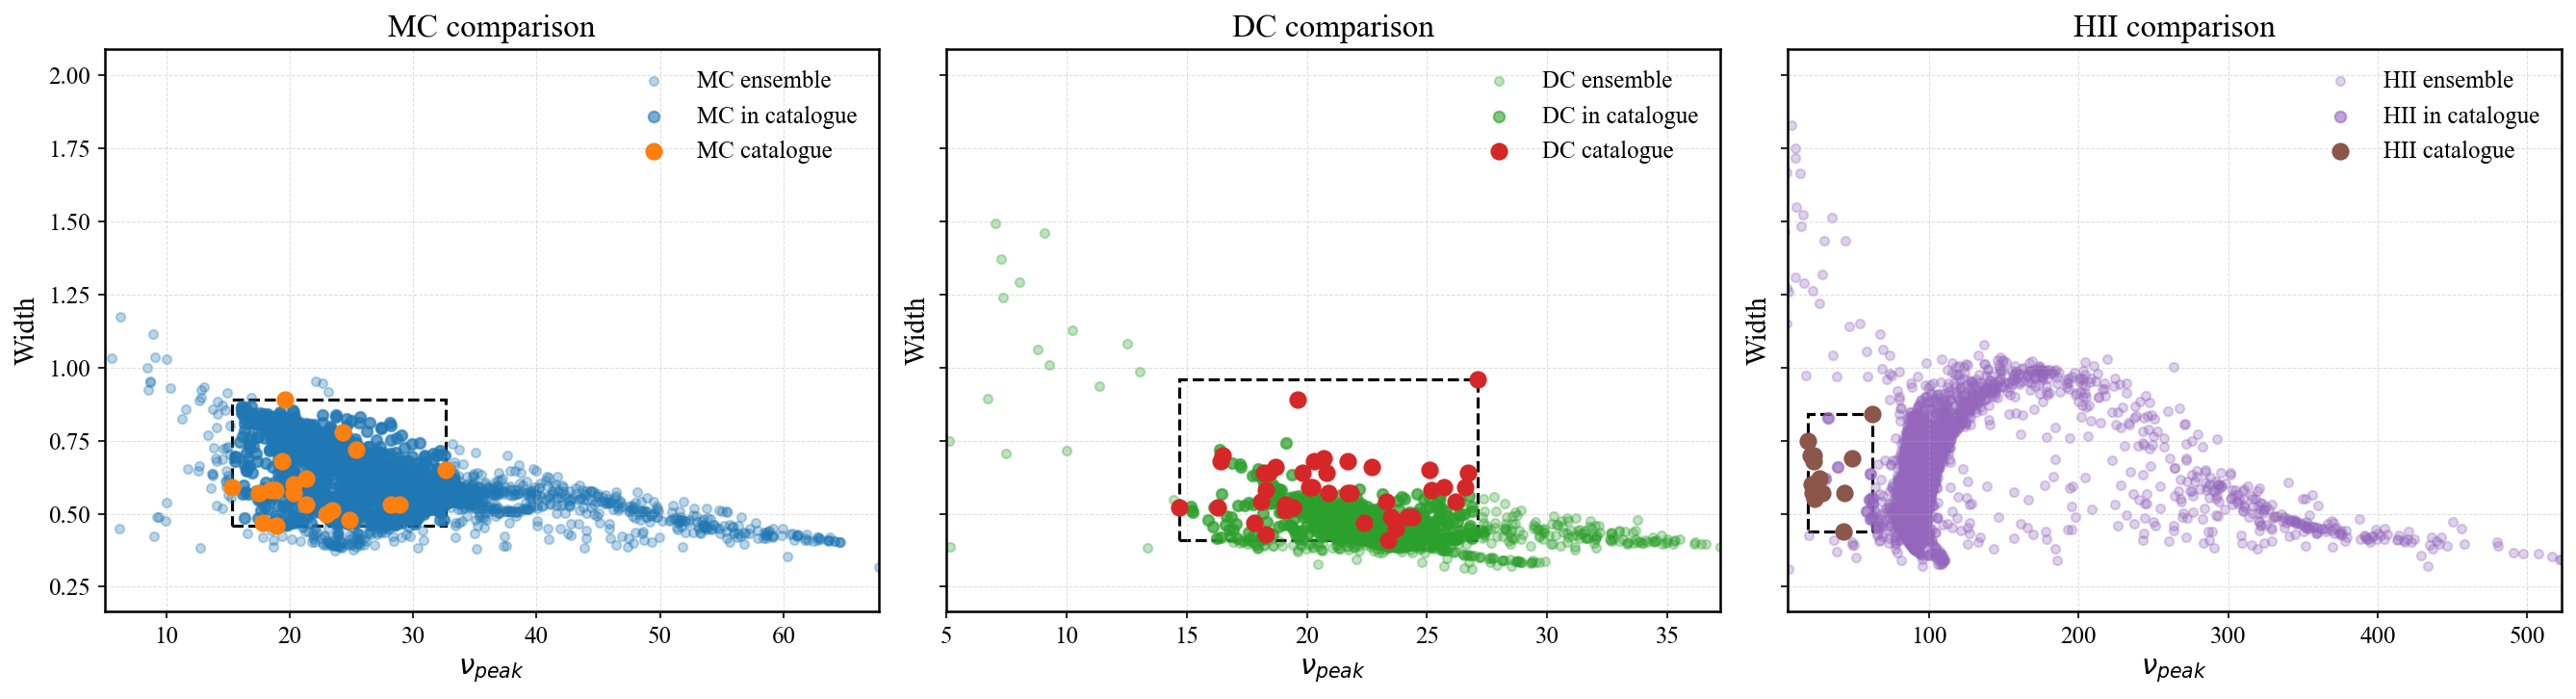

In [38]:
# Compare ensemble fits to catalogue measurements
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=True)
axes = np.atleast_1d(axes)

selection_masks = {}

scatter_configs = [
    ("MC", MC_dist_ensem_features, MC_catalogue, cm.tab10(0), cm.tab10(1)),
    ("DC", DC_dist_ensem_features, DC_catalogue, cm.tab10(2), cm.tab10(3)),
    ("HII", HII_dist_ensem_features, HII_catalogue, cm.tab10(4), cm.tab10(5)),
]

for ax, (label, ensemble_feats, catalogue_feats, ensemble_color, catalogue_color) in zip(axes, scatter_configs):
    ensemble_nu = ensemble_feats[:, 0]
    ensemble_width = ensemble_feats[:, 1]
    catalogue_nu = catalogue_feats[:, 0]
    catalogue_width = catalogue_feats[:, 1]

    nu_min, nu_max = catalogue_nu.min(), catalogue_nu.max()
    width_min, width_max = catalogue_width.min(), catalogue_width.max()
    rect = mpatches.Rectangle((nu_min, width_min), nu_max - nu_min, width_max - width_min,
                              facecolor="none", edgecolor="k", linewidth=1.5, linestyle="--")
    ax.add_patch(rect)

    mask = (ensemble_nu >= nu_min) & (ensemble_nu <= nu_max) & (ensemble_width >= width_min) & (ensemble_width <= width_max)
    selection_masks[label] = mask

    ax.scatter(ensemble_nu, ensemble_width, s=20, alpha=0.3, color=ensemble_color, label=f"{label} ensemble", zorder=1)
    ax.scatter(ensemble_nu[mask], ensemble_width[mask], s=30, alpha=0.6, color=ensemble_color, label=f"{label} in catalogue", zorder=2)
    ax.scatter(catalogue_nu, catalogue_width, s=60, color=catalogue_color, label=f"{label} catalogue", zorder=3)
    ax.set_title(f"{label} comparison")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    ax.set_xlim(5, ensemble_nu.max())
    ax.set_xlabel("$\\nu_{peak}$")
    ax.set_ylabel("Width")
    ax.legend(loc="best", frameon=False)

plt.tight_layout()
plt.show()

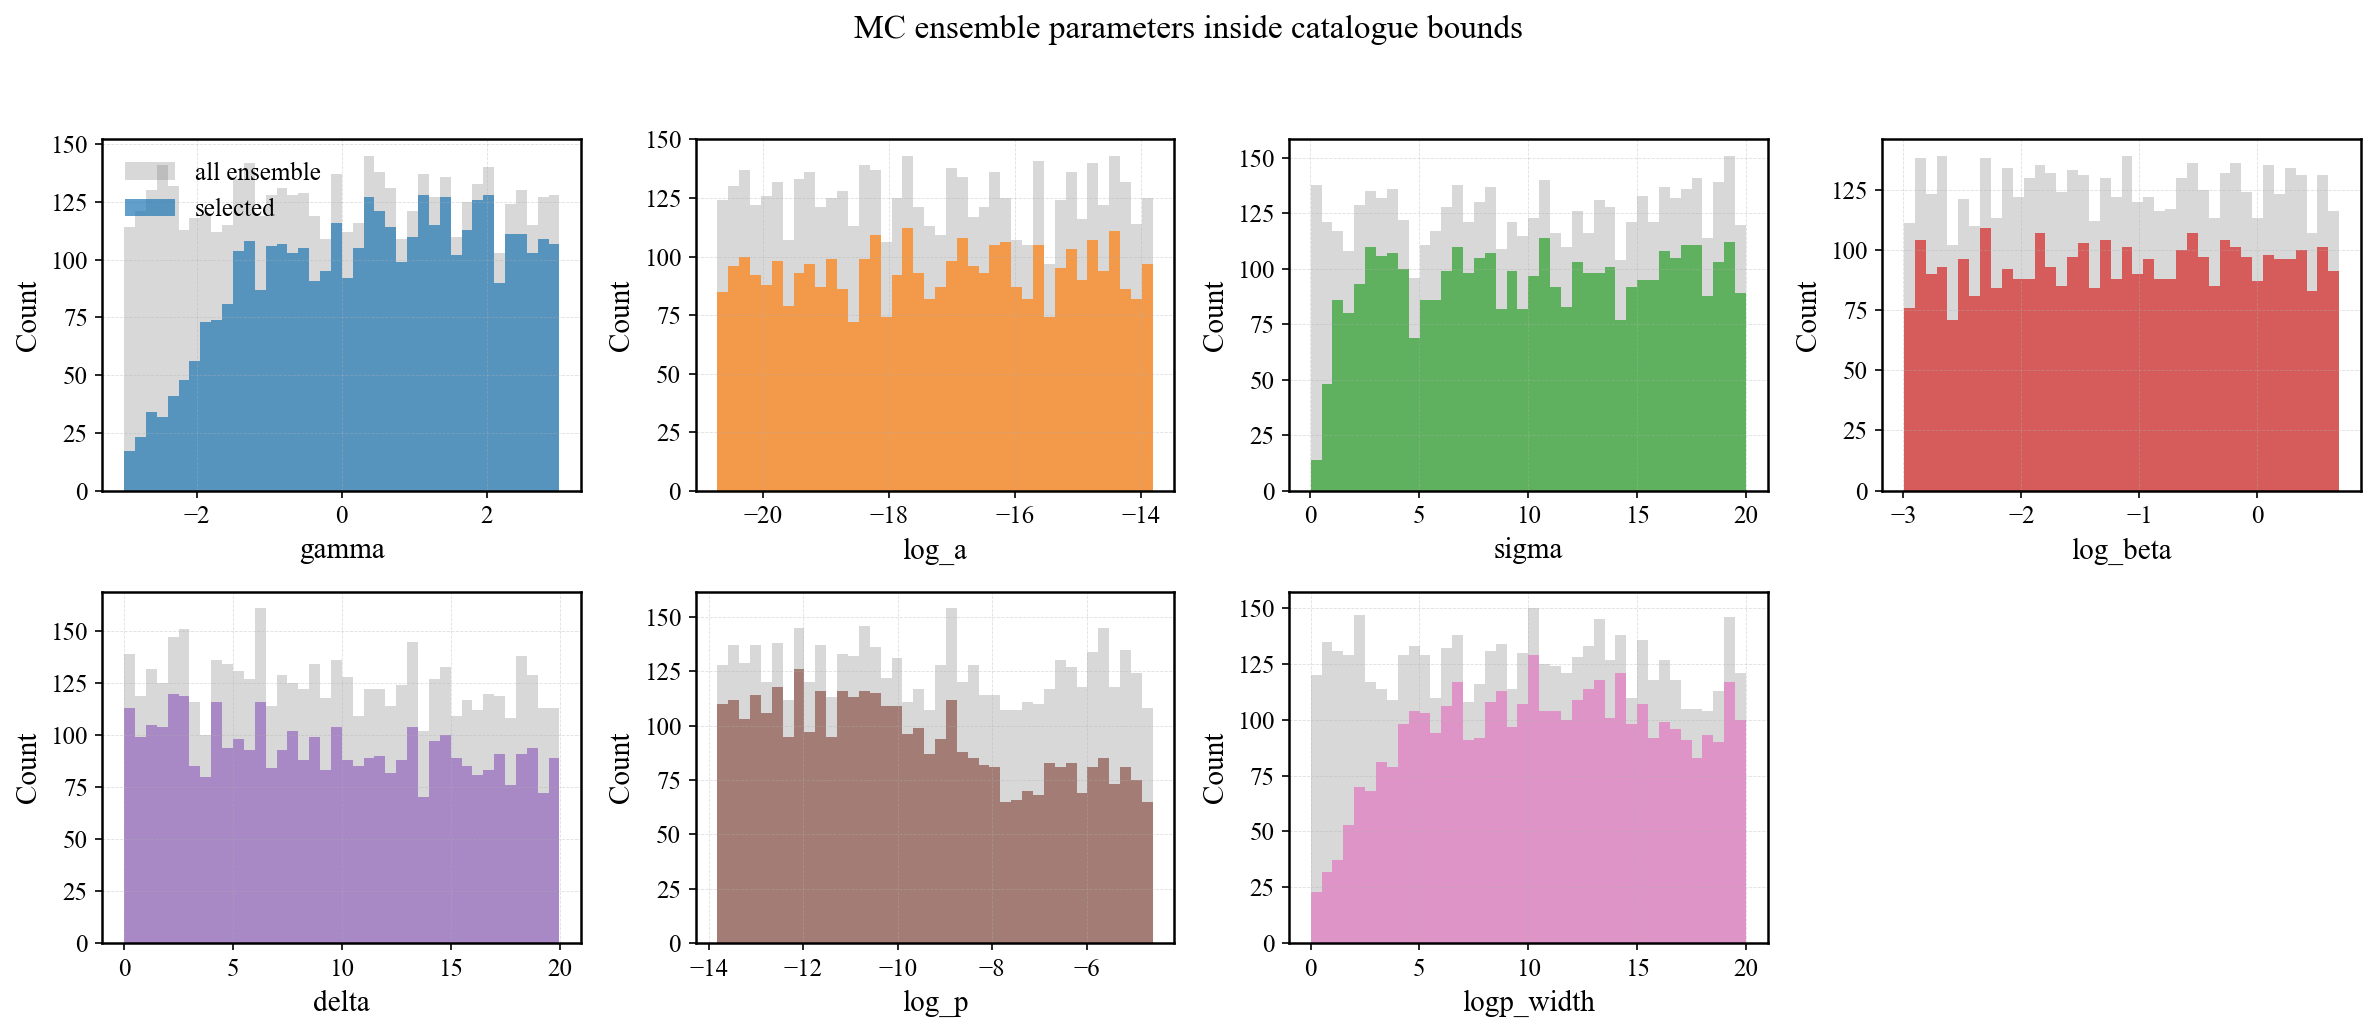

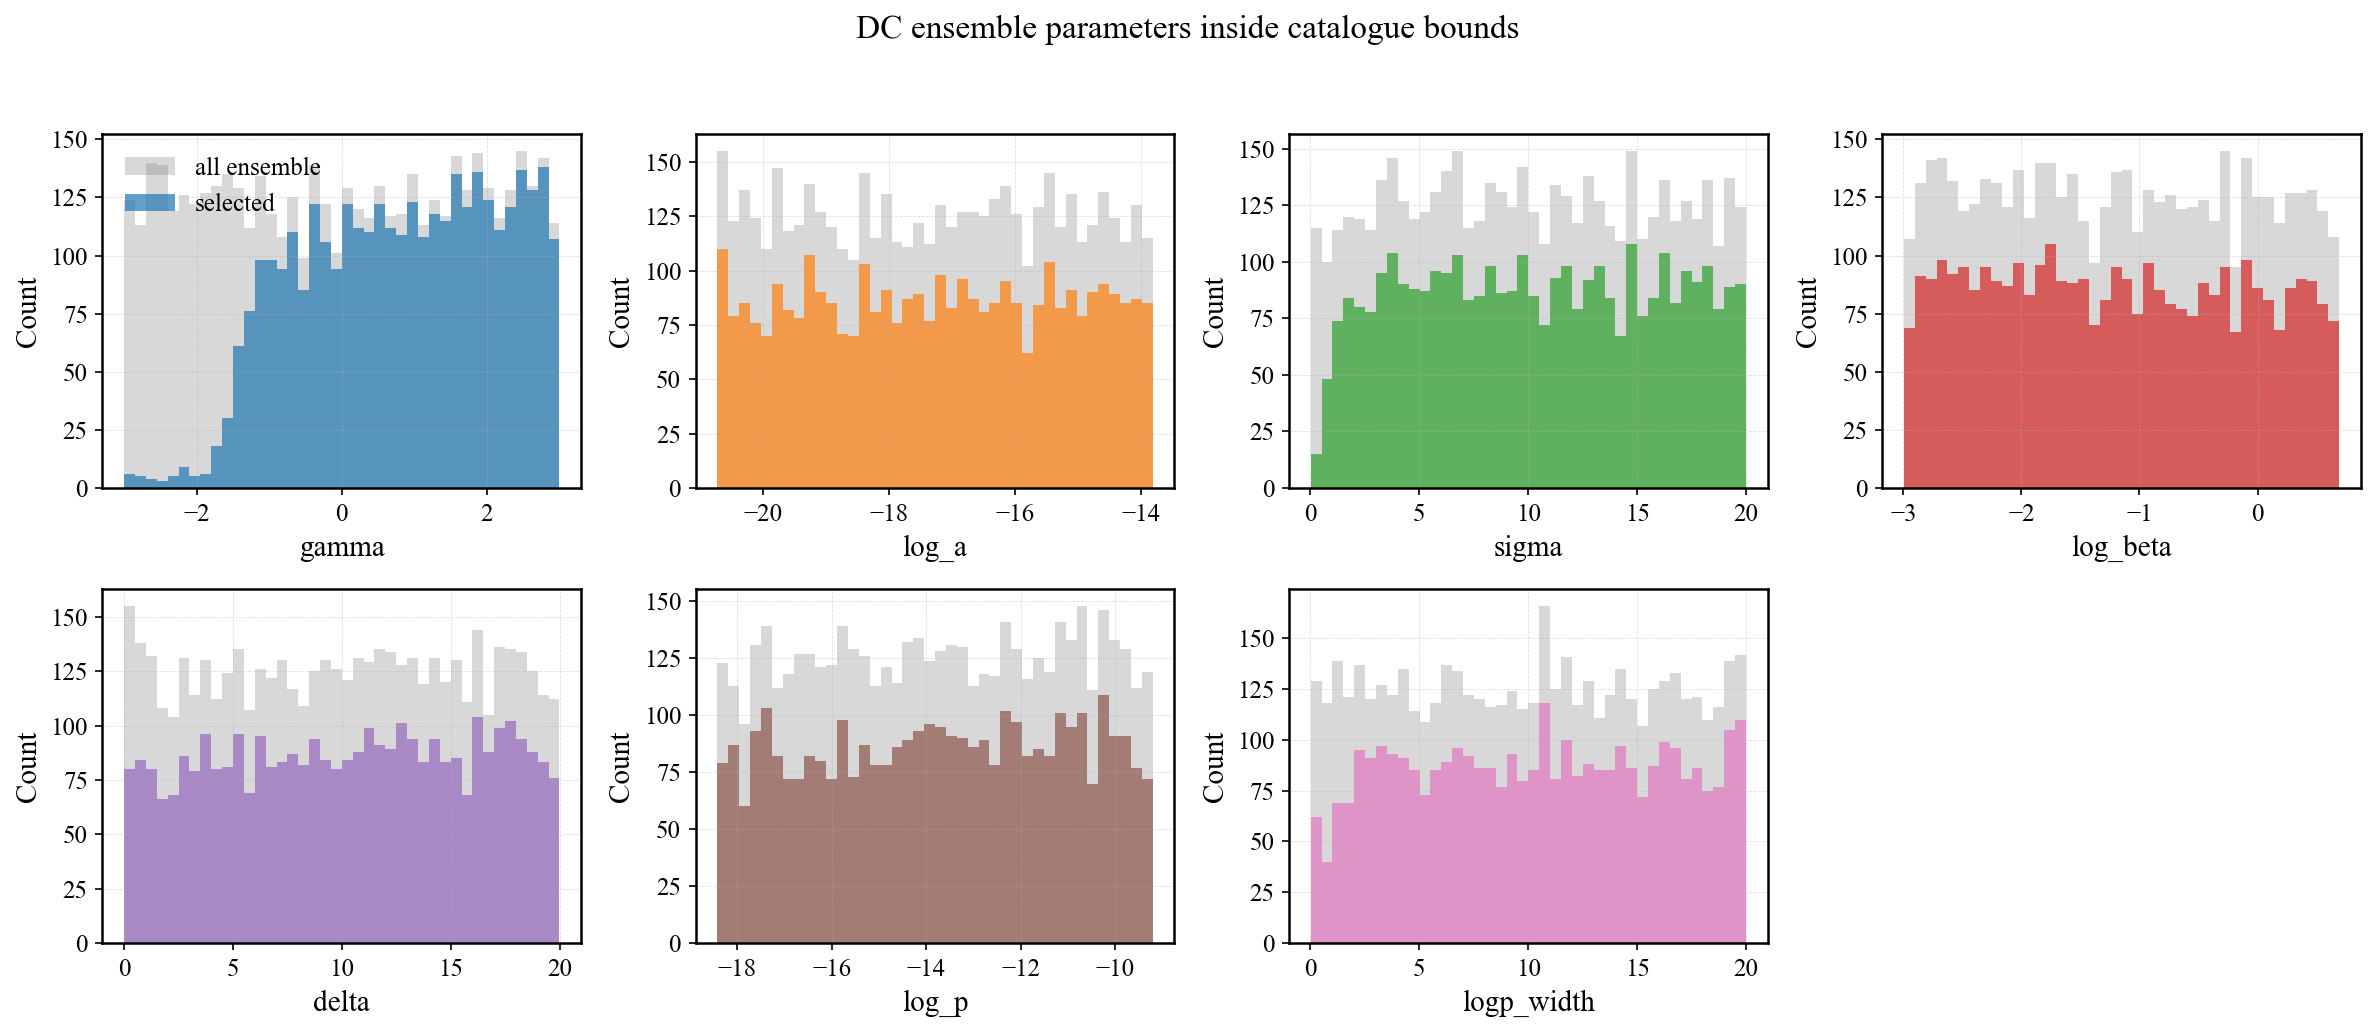

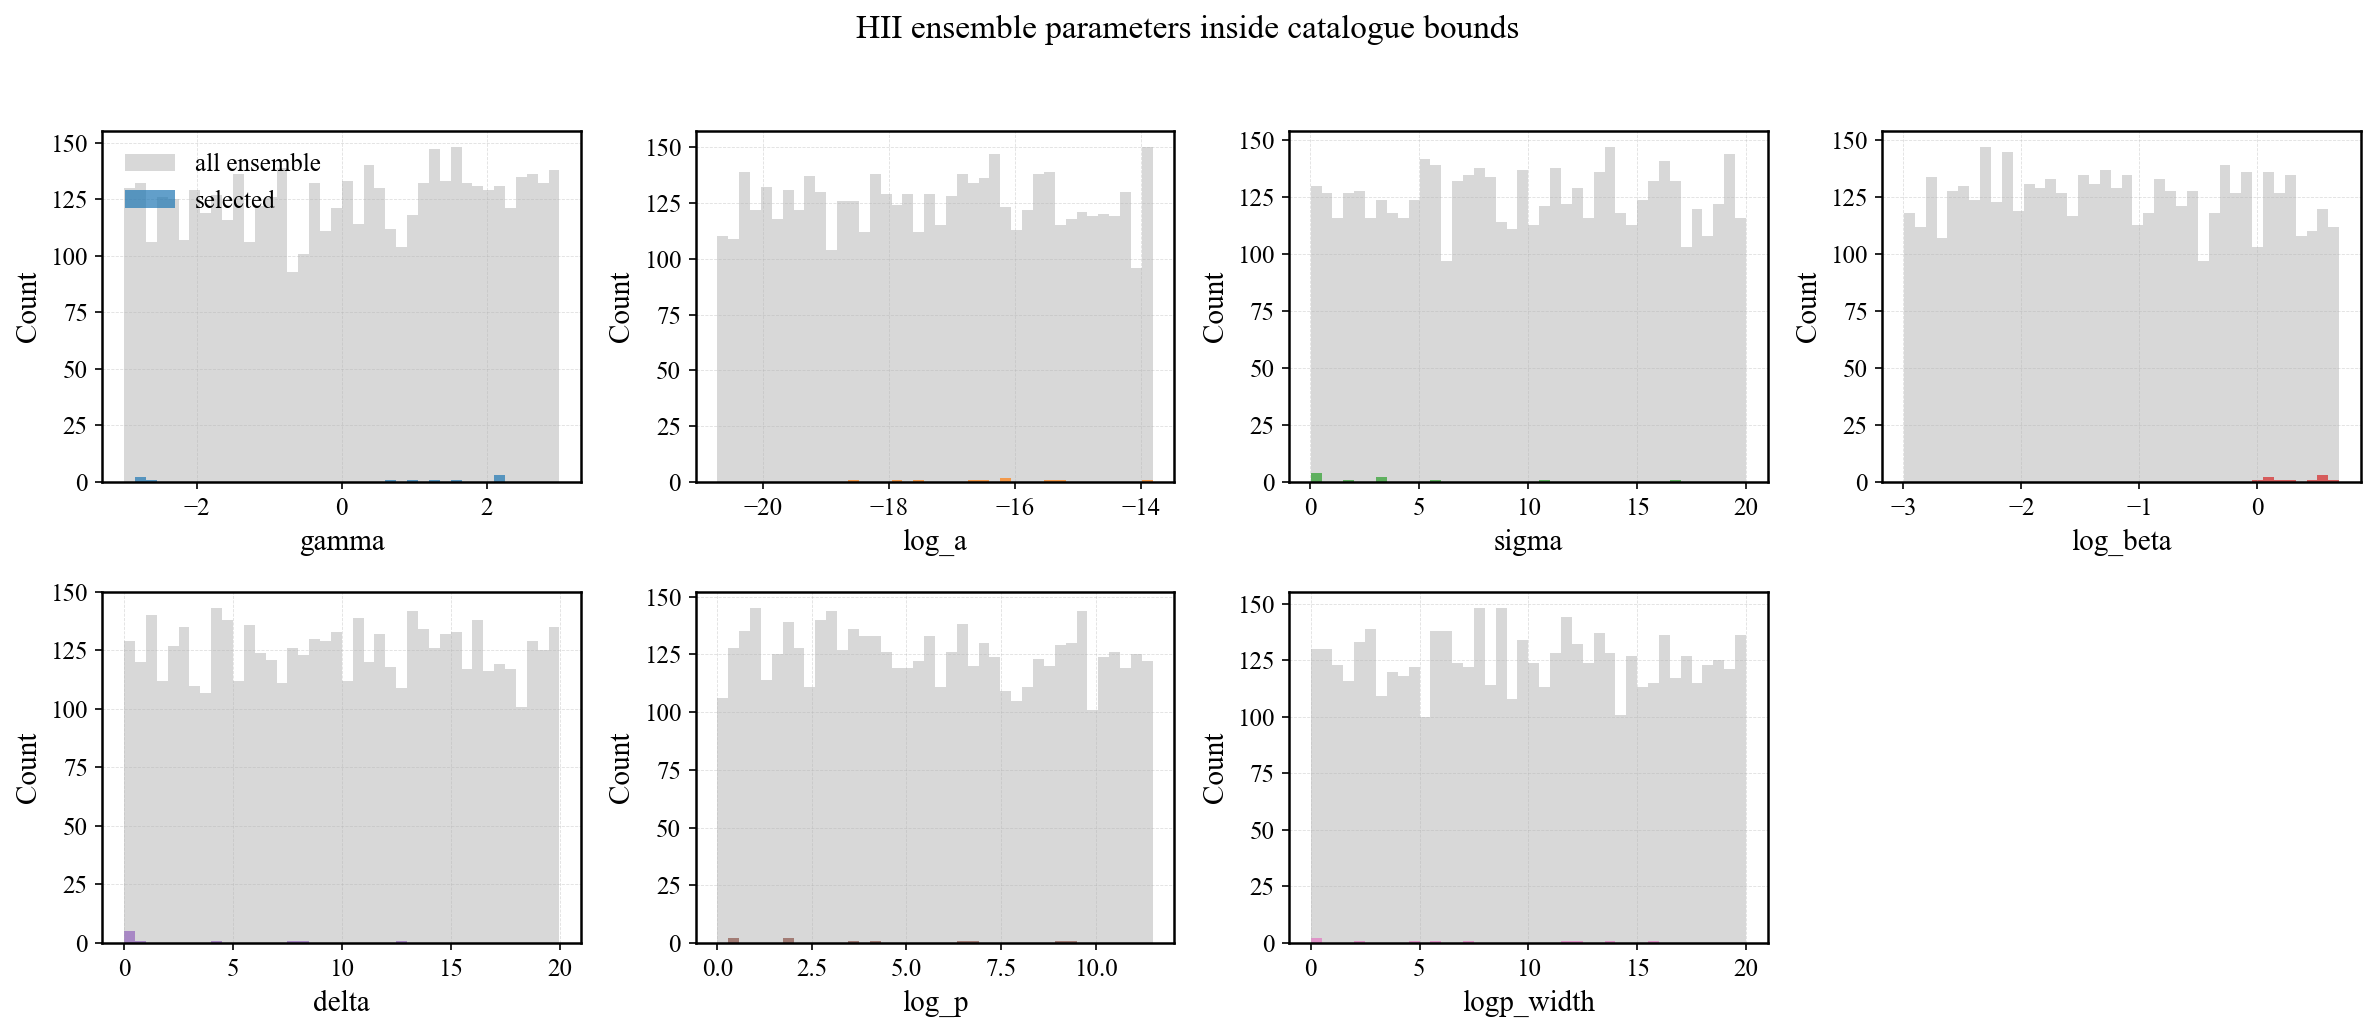

In [27]:
# Histograms of ensemble parameters selected within catalogue rectangle
selected_param_sets = {
    "MC": (MC_dist_ensem_params, selection_masks.get("MC", np.zeros(len(MC_dist_ensem_params), dtype=bool))),
    "DC": (DC_dist_ensem_params, selection_masks.get("DC", np.zeros(len(DC_dist_ensem_params), dtype=bool))),
    "HII": (HII_dist_ensem_params, selection_masks.get("HII", np.zeros(len(HII_dist_ensem_params), dtype=bool))),
}

if "param_names" not in globals():
    param_names = ["gamma", "log_a", "sigma", "log_beta", "delta", "log_p", "logp_width"]

for label, (params, mask) in selected_param_sets.items():
    selected = params[mask]
    fig, axes = plt.subplots(2, 4, figsize=(16, 7))
    axes = axes.ravel()
    fig.suptitle(f"{label} ensemble parameters inside catalogue bounds", fontsize=16)

    for idx, name in enumerate(param_names):
        ax = axes[idx]
        all_values = params[:, idx]
        bins = np.histogram_bin_edges(all_values, bins=40)
        ax.hist(all_values, bins=bins, color=cm.tab10(7), alpha=0.3, label="all ensemble")
        if selected.size:
            ax.hist(selected[:, idx], bins=bins, color=cm.tab10(idx % 10), alpha=0.7, label="selected")
        ax.set_xlabel(name)
        ax.set_ylabel("Count")
        ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.4)
    
    for ax in axes[len(param_names):]:
        ax.axis("off")

    axes[0].legend(loc="best", frameon=False)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()

In [64]:
class ensemble_fixed_beta_env(ensemble_model):
    gamma_min = -3.0
    gamma_max = 3.0

    log_a0_min = np.log(1e-9) 
    log_a0_max = np.log(1e-6)

    sigma_min = 0.01
    sigma_max = 20.0

    log_beta0_min = np.log(0.05)
    log_beta0_max = np.log(0.05)

    delta_min = 0.1
    delta_max = 0.1
    
    log_p_width_min = 0.1
    log_p_width_max = 0.1

N_samples = 5000

MC_dist_model_fixed_beta_env = ensemble_fixed_beta_env(log_p_c_min=np.log(1e-4), log_p_c_max=np.log(1e-4))
MC_dist_ensem_params_fixed_beta_env, MC_dist_ensem_sed_fixed_beta_env = MC_dist_model_fixed_beta_env.analysis(
    MC_key_params[:, [6,7,4]], 
    MC_sed_key_params, 
    num_samples=N_samples, 
    max_workers=30, 
    show_progress=True
)

In [65]:
DC_dist_model_fixed_beta_env = ensemble_fixed_beta_env(log_p_c_min=np.log(1e-6), log_p_c_max=np.log(1e-6))
DC_dist_ensem_params_fixed_beta_env, DC_dist_ensem_sed_fixed_beta_env = DC_dist_model_fixed_beta_env.analysis(
    DC_key_params[:, [6,7,4]], 
    DC_sed_key_params, 
    num_samples=N_samples, 
    max_workers=30, 
    show_progress=True
)

In [66]:
HII_dist_model_fixed_beta_env = ensemble_fixed_beta_env(log_p_c_min=np.log(1e4), log_p_c_max=np.log(1e4))
HII_dist_ensem_params_fixed_beta_env, HII_dist_ensem_sed_fixed_beta_env = HII_dist_model_fixed_beta_env.analysis(
    HII_key_params[:, [6,7,0]], 
    HII_sed_key_params, 
    num_samples=N_samples, 
    max_workers=30, 
    show_progress=True
)

In [67]:
np.savetxt("data/MC_dist_ensem_params_fixed_beta_env.txt", MC_dist_ensem_params_fixed_beta_env)
np.savetxt("data/MC_dist_ensem_sed_fixed_beta_env.txt", MC_dist_ensem_sed_fixed_beta_env)
np.savetxt("data/DC_dist_ensem_params_fixed_beta_env.txt", DC_dist_ensem_params_fixed_beta_env)
np.savetxt("data/DC_dist_ensem_sed_fixed_beta_env.txt", DC_dist_ensem_sed_fixed_beta_env)
np.savetxt("data/HII_dist_ensem_params_fixed_beta_env.txt", HII_dist_ensem_params_fixed_beta_env)
np.savetxt("data/HII_dist_ensem_sed_fixed_beta_env.txt", HII_dist_ensem_sed_fixed_beta_env)

In [68]:
MC_dist_ensem_features_fixed_beta_env = fit_sed_ensemble(
    freqs, 
    MC_dist_ensem_sed_fixed_beta_env, 
    thres=1e-3, 
    v2=False
)
MC_dist_ensem_features_fixed_beta_env[:, 0] = np.exp(MC_dist_ensem_features_fixed_beta_env[:, 0])

DC_dist_ensem_features_fixed_beta_env = fit_sed_ensemble(
    freqs, 
    DC_dist_ensem_sed_fixed_beta_env, 
    thres=1e-3, 
    v2=False
)
DC_dist_ensem_features_fixed_beta_env[:, 0] = np.exp(DC_dist_ensem_features_fixed_beta_env[:, 0])

HII_dist_ensem_features_fixed_beta_env = fit_sed_ensemble(
    freqs, 
    HII_dist_ensem_sed_fixed_beta_env, 
    thres=1e-3, 
    v2=False
)
HII_dist_ensem_features_fixed_beta_env[:, 0] = np.exp(HII_dist_ensem_features_fixed_beta_env[:, 0])

100%|██████████| 5000/5000 [00:01<00:00, 4281.34it/s]


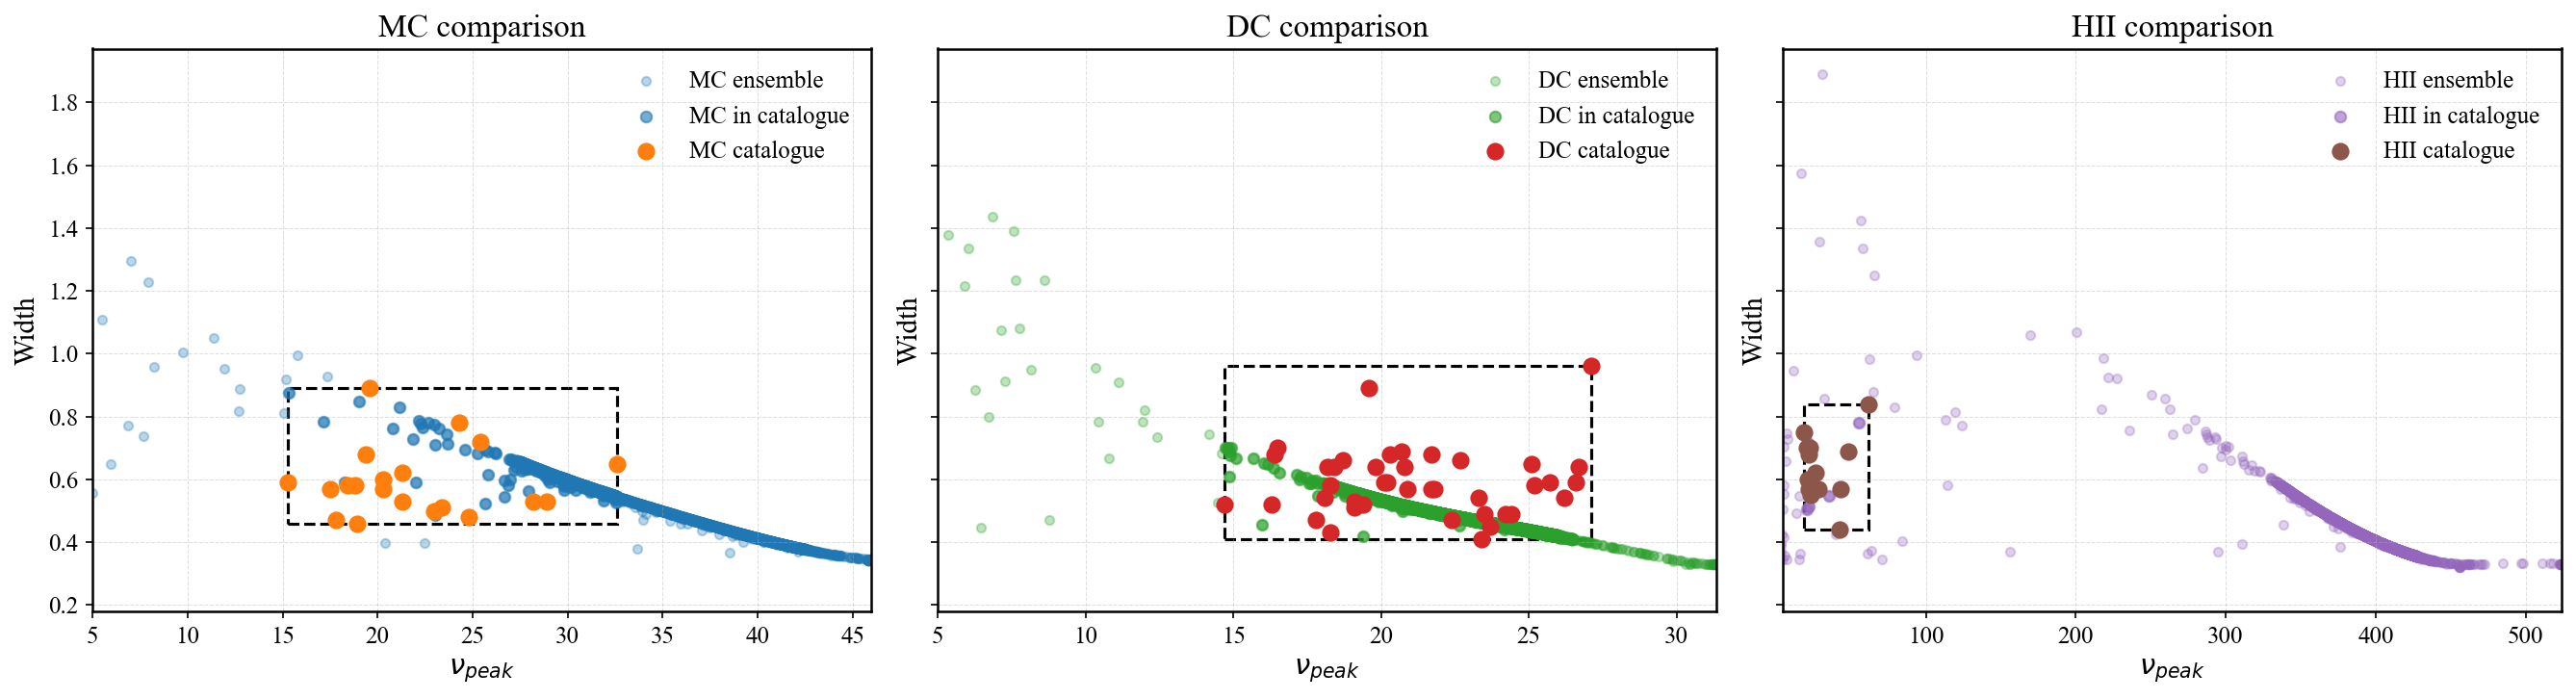

In [69]:
# Compare ensemble fits to catalogue measurements
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False, sharey=True)
axes = np.atleast_1d(axes)

selection_masks = {}

scatter_configs = [
    ("MC", MC_dist_ensem_features_fixed_beta_env, MC_catalogue, cm.tab10(0), cm.tab10(1)),
    ("DC", DC_dist_ensem_features_fixed_beta_env, DC_catalogue, cm.tab10(2), cm.tab10(3)),
    ("HII", HII_dist_ensem_features_fixed_beta_env, HII_catalogue, cm.tab10(4), cm.tab10(5)),
]

for ax, (label, ensemble_feats, catalogue_feats, ensemble_color, catalogue_color) in zip(axes, scatter_configs):
    ensemble_nu = ensemble_feats[:, 0]
    ensemble_width = ensemble_feats[:, 1]
    catalogue_nu = catalogue_feats[:, 0]
    catalogue_width = catalogue_feats[:, 1]

    nu_min, nu_max = catalogue_nu.min(), catalogue_nu.max()
    width_min, width_max = catalogue_width.min(), catalogue_width.max()
    rect = mpatches.Rectangle((nu_min, width_min), nu_max - nu_min, width_max - width_min,
                              facecolor="none", edgecolor="k", linewidth=1.5, linestyle="--")
    ax.add_patch(rect)

    mask = (ensemble_nu >= nu_min) & (ensemble_nu <= nu_max) & (ensemble_width >= width_min) & (ensemble_width <= width_max)
    selection_masks[label] = mask

    ax.scatter(ensemble_nu, ensemble_width, s=20, alpha=0.3, color=ensemble_color, label=f"{label} ensemble", zorder=1)
    ax.scatter(ensemble_nu[mask], ensemble_width[mask], s=30, alpha=0.6, color=ensemble_color, label=f"{label} in catalogue", zorder=2)
    ax.scatter(catalogue_nu, catalogue_width, s=60, color=catalogue_color, label=f"{label} catalogue", zorder=3)
    ax.set_title(f"{label} comparison")
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.4)
    ax.set_xlim(5, ensemble_nu.max())
    ax.set_xlabel("$\\nu_{peak}$")
    ax.set_ylabel("Width")
    ax.legend(loc="best", frameon=False)

plt.tight_layout()
plt.show()

## Moment Expansion

In [93]:
class MC_moment_expansion:
    nh = 3e2
    T = 20
    chi = 0.01
    xh = 0.0
    y = 0.99

    def __init__(self, pivots, order=2, step_sizes=None, default_freqs=None):
        pivots = np.asarray(pivots, dtype=float)
        if pivots.shape != (3,):
            raise ValueError("pivots must contain three values: (log_a, beta, log_xC).")
        self.param_names = ("log_a", "beta", "log_xC")
        self.pivot_a, self.pivot_beta, self.pivot_xC = pivots
        self.pivots = pivots
        self.order = self._validate_order(order)
        if step_sizes is None:
            step_sizes = self._default_step_sizes()
        else:
            step_sizes = np.asarray(step_sizes, dtype=float)
            if step_sizes.shape != (3,):
                raise ValueError("step_sizes must contain three positive values.")
            if np.any(step_sizes <= 0):
                raise ValueError("step_sizes must be strictly positive.")
        self.step_sizes = step_sizes
        if default_freqs is None:
            self.default_freqs = None
        else:
            default_freqs = np.asarray(default_freqs, dtype=float)
            if default_freqs.ndim != 1 or default_freqs.size == 0:
                raise ValueError("default_freqs must be a non-empty one-dimensional array.")
            self.default_freqs = default_freqs
        self.last_basis = None

    def _validate_order(self, order):
        if not isinstance(order, (int, np.integer)):
            raise ValueError("order must be an integer.")
        if order < 0 or order > 2:
            raise ValueError("order must be between 0 and 2.")
        return int(order)

    def _default_step_sizes(self):
        beta_scale = max(5e-3, 5e-3 * abs(self.pivot_beta))
        return np.array([5e-3, beta_scale, 5e-3], dtype=float)

    def _resolve_basis(self, freqs, basis, tumbling):
        """Return a basis compatible with the requested frequencies."""
        if basis is not None:
            return basis
        regenerate = False
        if self.last_basis is None:
            regenerate = True
        elif freqs is not None:
            freq_vec = np.asarray(freqs, dtype=float)
            if freq_vec.ndim != 1 or freq_vec.size == 0:
                raise ValueError("freqs must be a non-empty one-dimensional array.")
            if not np.array_equal(freq_vec, np.asarray(self.last_basis["freqs"], dtype=float)):
                regenerate = True
        if regenerate:
            basis = self.generate_SED_basis(freqs=freqs, tumbling=tumbling)
        else:
            basis = self.last_basis
        return basis

    def _assemble_design_matrix(self, basis, max_order, include_zeroth):
        """Construct a design matrix up to max_order from the cached basis."""
        max_order = int(max_order)
        columns = []
        labels = []
        if include_zeroth:
            if "zeroth" not in basis:
                raise ValueError("Basis is missing the zeroth-order SED.")
            columns.append(np.asarray(basis["zeroth"], dtype=float))
            labels.append("zeroth")
        if max_order >= 1:
            first = basis.get("first")
            if first is None:
                raise ValueError("First-order derivatives are not available in the basis.")
            for name in self.param_names:
                if name not in first:
                    raise KeyError(f"Missing first-order derivative for parameter '{name}'.")
                columns.append(np.asarray(first[name], dtype=float))
                labels.append(f"first:{name}")
        if max_order >= 2:
            second = basis.get("second")
            if second is None or "diag" not in second or "cross" not in second:
                raise ValueError("Second-order derivatives are not available in the basis.")
            diag = second["diag"]
            cross = second["cross"]
            for name in self.param_names:
                if name not in diag:
                    raise KeyError(f"Missing second-order diagonal term for parameter '{name}'.")
                columns.append(np.asarray(diag[name], dtype=float))
                labels.append(f"second_diag:{name}")
            for i in range(len(self.param_names)):
                for j in range(i + 1, len(self.param_names)):
                    key = (self.param_names[i], self.param_names[j])
                    if key not in cross:
                        raise KeyError(f"Missing second-order cross term for parameters {key}.")
                    columns.append(np.asarray(cross[key], dtype=float))
                    labels.append(f"second_cross:{key[0]}:{key[1]}")
        if not columns:
            raise ValueError("Requested basis does not add any columns. Adjust order or include_zeroth.")
        design_matrix = np.column_stack(columns)
        return design_matrix, labels

    def generate_SED(self, log_a, beta, log_xC, freq_coords=None, tumbling=True):
        """Generate an SED for a single grain configuration using SpyDust."""
        log_a = float(log_a)
        beta = float(beta)
        log_xC = float(log_xC)

        if freq_coords is not None:
            target_freqs = np.asarray(freq_coords, dtype=float)
            if target_freqs.ndim != 1:
                raise ValueError("freq_coords must be a one-dimensional array of frequencies.")
            if target_freqs.size == 0:
                raise ValueError("freq_coords cannot be empty.")
            span = max(target_freqs.max() - target_freqs.min(), 1.0)
            pad = max(0.01 * span, 0.05)
            min_freq = max(target_freqs.min() - pad, 1e-3)
            max_freq = target_freqs.max() + pad
            n_freq = max(300, int(np.ceil(target_freqs.size * 1.5)))
        else:
            target_freqs = None
            min_freq = None
            max_freq = None
            n_freq = 300

        a = np.exp(log_a)
        xC = np.exp(log_xC)
        if not np.isfinite(a) or not np.isfinite(xC):
            raise ValueError("Provided log parameters lead to non-finite grain properties.")

        a2_aux = 2.0 * a if tumbling else a / 2.0
        env = {
            'nh': self.nh,
            'T': self.T,
            'Chi': self.chi,
            'xh': self.xh,
            'xC': xC,
            'y': self.y,
            'gamma': 0,
            'dipole': 9.3,
        }
        freqs_native, sed_native = SpyDust_given_grain_size_shape(
            env,
            a,
            beta,
            tumbling=tumbling,
            min_freq=min_freq,
            max_freq=max_freq,
            n_freq=n_freq,
            N_angular_Omega=500,
            a2=a2_aux,
        )
        freqs_native = np.asarray(freqs_native, dtype=float)
        sed_native = np.asarray(sed_native, dtype=float)

        if target_freqs is None:
            return freqs_native, sed_native

        if not np.all(np.diff(freqs_native) >= 0):
            sort_idx = np.argsort(freqs_native)
            freqs_native = freqs_native[sort_idx]
            sed_native = sed_native[sort_idx]

        tol = 5e-4 * max(1.0, freqs_native.max())
        if target_freqs.min() < freqs_native.min() - tol or target_freqs.max() > freqs_native.max() + tol:
            raise ValueError("freq_coords must lie within the native SpyDust frequency grid.")

        if not np.all(np.diff(target_freqs) >= 0):
            order_idx = np.argsort(target_freqs)
            sorted_target = target_freqs[order_idx]
            interpolated = np.interp(sorted_target, freqs_native, sed_native)
            reverse_idx = np.argsort(order_idx)
            interpolated = interpolated[reverse_idx]
            return target_freqs, interpolated

        interpolated = np.interp(target_freqs, freqs_native, sed_native)
        return target_freqs, interpolated

    def generate_SED_basis(self, pivots=None, freqs=None, order=2, tumbling=True):
        if pivots is None:
            pivot_vec = self.pivots
        else:
            pivot_vec = np.asarray(pivots, dtype=float)
            if pivot_vec.shape != (3,):
                raise ValueError("pivots must contain three values: (log_a, beta, log_xC).")
        if freqs is None:
            if self.default_freqs is None:
                raise ValueError("freqs cannot be None when constructing the SED basis.")
            freq_coords = self.default_freqs
        else:
            freq_coords = np.asarray(freqs, dtype=float)
            if freq_coords.ndim != 1 or freq_coords.size == 0:
                raise ValueError("freqs must be a one-dimensional array of frequencies.")

        target_order = self.order
        if order is not None:
            target_order = min(self._validate_order(order), target_order)

        freq_grid, sed0 = self.generate_SED(*pivot_vec, freq_coords=freq_coords, tumbling=tumbling)
        freq_grid = np.asarray(freq_grid, dtype=float)
        sed0 = np.asarray(sed0, dtype=float)

        step_sizes = self.step_sizes
        unit_vectors = np.eye(3, dtype=int)
        cache = {(0, 0, 0): sed0.copy()}

        def evaluate(multipliers):
            # Cache SED evaluations keyed by finite-difference multipliers.
            key = tuple(int(m) for m in multipliers)
            if key in cache:
                return cache[key]
            delta = step_sizes * np.array(key, dtype=float)
            params = pivot_vec + delta
            freq_eval, sed_eval = self.generate_SED(*params, freq_coords=freq_coords, tumbling=tumbling)
            if not np.allclose(freq_eval, freq_grid, rtol=0, atol=1e-6):
                raise ValueError("Frequency grid mismatch encountered while constructing the basis.")
            cache[key] = sed_eval
            return sed_eval

        basis = {
            "freqs": freq_grid,
            "zeroth": sed0,
            "pivots": pivot_vec,
            "step_sizes": step_sizes.copy(),
            "order": target_order,
        }

        if target_order >= 1:
            first_derivs = {}
            for idx, name in enumerate(self.param_names):
                e = unit_vectors[idx]
                sed_plus = evaluate(e)
                sed_minus = evaluate(-e)
                first_derivs[name] = (sed_plus - sed_minus) / (2.0 * step_sizes[idx])
            basis["first"] = first_derivs

        if target_order >= 2:
            second_diag = {}
            second_cross = {}
            for idx, name in enumerate(self.param_names):
                e = unit_vectors[idx]
                sed_plus = evaluate(e)
                sed_minus = evaluate(-e)
                second_diag[name] = (sed_plus - 2.0 * sed0 + sed_minus) / (step_sizes[idx] ** 2)
            for i in range(len(self.param_names)):
                for j in range(i + 1, len(self.param_names)):
                    key = (self.param_names[i], self.param_names[j])
                    e_i = unit_vectors[i]
                    e_j = unit_vectors[j]
                    sed_pp = evaluate(e_i + e_j)
                    sed_pm = evaluate(e_i - e_j)
                    sed_mp = evaluate(-e_i + e_j)
                    sed_mm = evaluate(-e_i - e_j)
                    second_cross[key] = (sed_pp - sed_pm - sed_mp + sed_mm) / (4.0 * step_sizes[i] * step_sizes[j])
            basis["second"] = {"diag": second_diag, "cross": second_cross}

        self.last_basis = basis
        return basis

    def evaluate_expansion(self, samples, basis=None, order=None):
        if basis is None:
            if self.last_basis is None:
                raise ValueError("No cached basis available. Call generate_SED_basis first.")
            basis = self.last_basis

        samples = np.asarray(samples, dtype=float)
        squeeze = False
        if samples.ndim == 1:
            if samples.size != 3:
                raise ValueError("samples must have three entries: (log_a, beta, log_xC).")
            samples = samples[None, :]
            squeeze = True
        elif samples.shape[1] != 3:
            raise ValueError("samples must have shape (N, 3).")

        if order is None:
            resolved_order = min(self.order, basis["order"])
        else:
            resolved_order = self._validate_order(order)
            resolved_order = min(resolved_order, self.order, basis["order"])

        freqs = basis["freqs"]
        pivot_vec = np.asarray(basis["pivots"], dtype=float)

        approximations = []
        for sample in samples:
            delta = sample - pivot_vec
            sed = np.asarray(basis["zeroth"], dtype=float).copy()
            if resolved_order >= 1:
                for idx, name in enumerate(self.param_names):
                    sed = sed + delta[idx] * basis["first"][name]
            if resolved_order >= 2:
                diag_terms = basis["second"]["diag"]
                cross_terms = basis["second"]["cross"]
                for idx, name in enumerate(self.param_names):
                    sed = sed + 0.5 * (delta[idx] ** 2) * diag_terms[name]
                for i in range(len(self.param_names)):
                    for j in range(i + 1, len(self.param_names)):
                        key = (self.param_names[i], self.param_names[j])
                        sed = sed + delta[i] * delta[j] * cross_terms[key]
            approximations.append(sed)

        approximations = np.asarray(approximations)
        if squeeze:
            approximations = approximations[0]

        return freqs, approximations

    def fit_basis_functions(self, target_sed, freqs=None, basis=None, order=None, include_zeroth=True, weights=None, rcond=None, return_fitted=False, tumbling=True):
        """Fit the target SED using all available basis functions up to the requested order."""
        target = np.asarray(target_sed, dtype=float)
        if target.ndim != 1 or target.size == 0:
            raise ValueError("target_sed must be a non-empty one-dimensional array.")

        basis = self._resolve_basis(freqs, basis, tumbling)
        if order is None:
            resolved_order = min(self.order, basis["order"])
        else:
            resolved_order = self._validate_order(order)
            resolved_order = min(resolved_order, self.order, basis["order"])

        freqs_basis = np.asarray(basis["freqs"], dtype=float)
        if target.shape != freqs_basis.shape:
            raise ValueError("target_sed must have the same shape as the basis frequency grid.")

        design_matrix, column_labels = self._assemble_design_matrix(basis, resolved_order, include_zeroth)
        design_matrix = np.asarray(design_matrix, dtype=float)

        weighted_matrix = design_matrix
        weighted_target = target
        if weights is not None:
            weights = np.asarray(weights, dtype=float)
            if weights.shape != target.shape:
                raise ValueError("weights must match the SED shape.")
            if np.any(weights < 0):
                raise ValueError("weights must be non-negative.")
            sqrt_w = np.sqrt(weights)
            weighted_matrix = design_matrix * sqrt_w[:, None]
            weighted_target = target * sqrt_w

        coeffs, _, _, _ = np.linalg.lstsq(weighted_matrix, weighted_target, rcond=rcond)
        fitted_sed = design_matrix @ coeffs

        result = {
            "freqs": freqs_basis,
            "coefficients": coeffs,
            "coefficient_labels": column_labels,
            "coefficients_map": dict(zip(column_labels, coeffs)),
            "order": resolved_order,
        }
        if return_fitted:
            result["fitted_sed"] = fitted_sed
            result["residual"] = target - fitted_sed

        return result

    def fit_linear_basis(self, target_sed, freqs=None, basis=None, weights=None, rcond=None, return_fitted=False, tumbling=True):
        """Fit a target SED with the linear (first-order) basis functions."""
        target = np.asarray(target_sed, dtype=float)
        if target.ndim != 1 or target.size == 0:
            raise ValueError("target_sed must be a non-empty one-dimensional array.")

        basis = self._resolve_basis(freqs, basis, tumbling)
        if basis.get("order", 0) < 1 or "first" not in basis:
            raise ValueError("The provided basis does not contain first-order derivatives.")

        freqs_basis = np.asarray(basis["freqs"], dtype=float)
        if target.shape != freqs_basis.shape:
            raise ValueError("target_sed must have the same shape as the basis frequency grid.")

        zeroth = np.asarray(basis["zeroth"], dtype=float)
        residual = target - zeroth

        design_matrix, _ = self._assemble_design_matrix(basis, max_order=1, include_zeroth=False)
        design_matrix = np.asarray(design_matrix, dtype=float)

        weighted_matrix = design_matrix
        weighted_residual = residual
        if weights is not None:
            weights = np.asarray(weights, dtype=float)
            if weights.shape != target.shape:
                raise ValueError("weights must match the SED shape.")
            if np.any(weights < 0):
                raise ValueError("weights must be non-negative.")
            sqrt_w = np.sqrt(weights)
            weighted_matrix = design_matrix * sqrt_w[:, None]
            weighted_residual = residual * sqrt_w

        coeffs, _, _, _ = np.linalg.lstsq(weighted_matrix, weighted_residual, rcond=rcond)
        fitted_delta = coeffs
        fitted_sample = np.asarray(basis["pivots"], dtype=float) + fitted_delta
        fitted_sed = zeroth + (design_matrix @ coeffs)

        result = {
            "freqs": freqs_basis,
            "delta_params": dict(zip(self.param_names, fitted_delta)),
            "sample": fitted_sample,
            "coefficients": coeffs,
            "coefficients_map": dict(zip(self.param_names, coeffs)),
        }

        if return_fitted:
            result["fitted_sed"] = fitted_sed
            result["residual"] = target - fitted_sed

        return result

In [96]:
idx = np.where((freqs >= 15) & (freqs <= 80))[0]
freqs_fit = freqs[idx]
examples_to_fit = MC_dist_ensem_sed[:, idx]

pivots = [np.log(5e-8), -0.45, np.log(1e-4)]
MCME = MC_moment_expansion(pivots, default_freqs=freqs_fit)

fit_result = MCME.fit_basis_functions(
    target_sed=examples_to_fit[0], 
    freqs=freqs_fit, 
    order=2, 
    include_zeroth=True, 
    return_fitted=True, 
    tumbling=True
)


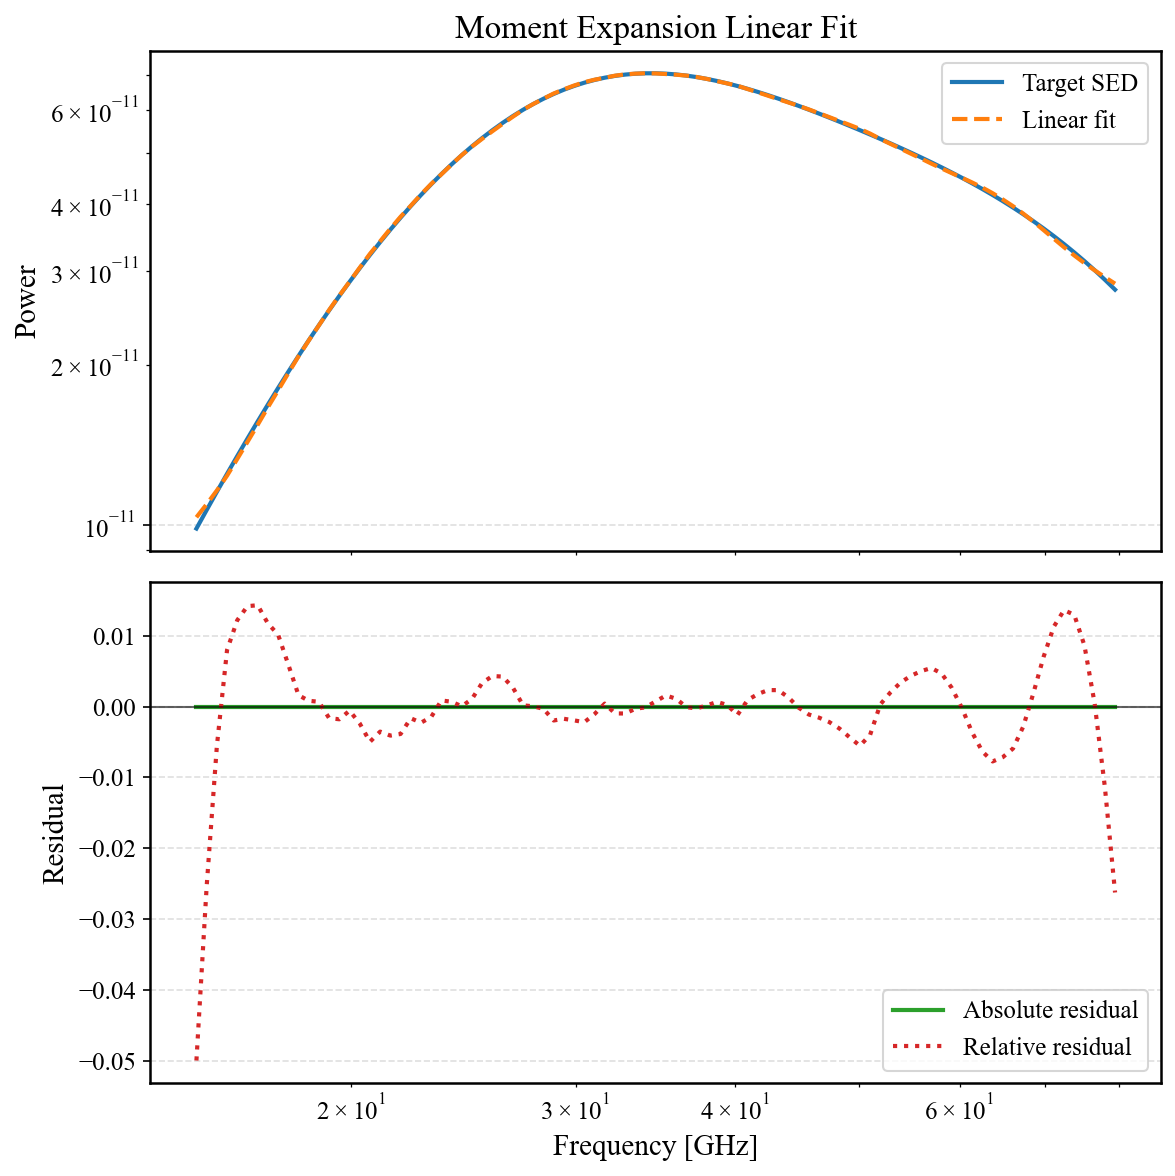

In [97]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax_sed, ax_resid = axes

freqs_plot = fit_result["freqs"]
target_sed = examples_to_fit[0]
fitted_sed = fit_result["fitted_sed"]
residual = fit_result["residual"]
relative_residual = residual / np.maximum(target_sed, 1e-30)

ax_sed.plot(freqs_plot, target_sed, label="Target SED", color="tab:blue")
ax_sed.plot(freqs_plot, fitted_sed, label="Linear fit", color="tab:orange", linestyle="--")
ax_sed.set_ylabel("Power")
ax_sed.set_xscale("log")
ax_sed.set_yscale("log")
ax_sed.set_title("Moment Expansion Linear Fit")
ax_sed.legend(loc="best")
ax_sed.grid(True, linestyle="--", alpha=0.4)

ax_resid.plot(freqs_plot, residual, color="tab:green", label="Absolute residual")
ax_resid.plot(freqs_plot, relative_residual, color="tab:red", linestyle=":", label="Relative residual")
ax_resid.axhline(0.0, color="black", linewidth=1, alpha=0.6)
ax_resid.set_xlabel("Frequency [GHz]")
ax_resid.set_ylabel("Residual")
ax_resid.legend(loc="best")
ax_resid.grid(True, linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()